<a href="https://colab.research.google.com/github/ChuLiangFu/18337/blob/master/01.28-Friday/01_reaction-diffusion-systems-py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gray-Scott Model of Reaction-Diffusion

![reaction-diffusion](https://drive.google.com/uc?id=1xUwfPlNcjWgzBl7Mizh32RDpiP1sw6us)

The Gray-Scott model of reaction-diffusion models two interacting species, $U$ and $V$, that both react and diffuse in space. The chemical reaction between the two species is given by

$$
\begin{aligned}
U + 2V &\rightarrow 3V \\
V &\rightarrow P
\end{aligned}
$$

where $P$ represents an inert product that depletes the amount of $V$ present. Each species $U$ and $V$ has a corresponding concentration, $u$ and $v$, respectively. The evolution of the concentrations in time is given by the following system of partial differential equations (PDE):

$$
\begin{aligned}
\frac{\partial{u}}{\partial{t}} &= D_u\nabla^2u - uv^2 + f(1-u) \\
\frac{\partial{v}}{\partial{t}} &= D_v\nabla^2v + uv^2 - (f+k)v
\end{aligned}
$$

Let's break down the contributions to these equations.

#### Diffusion
$D_u$ and $D_v$ represent the diffusion constants of each species, and $\nabla^2$ is the Laplace operator in 2D, given by

$$ \nabla^2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}.$$ 

Both species respond to the concentrations of their surroundings. If more $U$ is present at a particular point than in its surroundings, $\nabla^2u$ will be negative, and $u$ will decrease at that point.

#### Reaction
According to the chemical reaction, one $U$ and two $V$ react to produce $3V$; as a result, the reaction *rate* is proportional to $uv^2$. This reaction depletes $u$ but increases $v$ in the differential equation.

#### Replenishment
The species $U$ is replenished from the environment (e.g. an adjacent reservoir) in proportion to $1-u$, with a constant of proportionality $f$ known as the *feed rate*. The feed rate is one of the key parameters we will tune to observe different patterns.

#### Depletion
The species $V$ depletes by forming an inert product $P$. This depletion proceeds at a rate proportional to $v$ and the sum $f+k$, where $k$ is known as the *kill rate*. This is the second term we will tune to vary the pattern formation.

Our goal in this session will be to explore the variety of interesting visual patterns this simple yet rich interacting system can exhibit, which have analogs in biological pattern formation such as spots or stripes. For reference, the following website offers an interactive look into the phase diagram spanned by the $f$ and $k$ parameters: [Reaction-Diffusion by the Gray-Scott Model: Pearson's Parametrization](http://mrob.com/pub/comp/xmorphia/index.html).

We'll start by importing the necessary libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import ipywidgets as widgets
from skimage.data import binary_blobs
from skimage.io import imread
from scipy.integrate import solve_ivp
from IPython.display import HTML, display

Below, we define two functions which we will use to format and make plots and animations.

In [2]:
def plot_pattern(u, colormap='twilight'):
    '''Plot the concentration as a color image.
    u - grid of concentrations of one species.
    colormap - an optional specification for a colormap to use.
    '''
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    im = ax.imshow(u, cmap=plt.get_cmap(colormap),
                   vmin = 0.2, vmax = 1,
                   interpolation='bicubic',
                   extent=[-1, 1, -1, 1], alpha=0.8)
    ax.tick_params(labelsize=14)
    ax.set_xlim(-1,1); ax.set_ylim(-1,1)
    ax.axis('off')
    ax.grid(False)
    
    # return handles to figure, axis, and image
    return fig, ax, im

def animate_pattern(out, colormap='twilight'):
    '''
    Animate the concentration over time.
    out - 3d array of frames.
    colormap - an optional specification for a colormap to use.
    '''
    frames = out.shape[-1]
    fig, ax, im = plot_pattern(out[:,:,0], colormap)

    def animate(i):
        '''Plot updates for animation.'''
        im.set_array(out[:,:,i])
        return im,

    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=100, blit=True)
    plt.close(fig)
    return ani

The initialization of our system requires preparing two $N\times N$ grids: one for the concentration $u$ of the first species, and the other the concentration $v$ of the second species. We will use a built-in function ```binary_blobs``` which generates a binary image of random, blob-like structures. Where our image is 1, we will initialize $u$ to $0.5$, and to $1$ otherwise. Where our image is 1, we will initialize $v$ to $0.25$, and to $0$ otherwise. Optionally, we also provide an argument to invert the background; instead of a $U$-dominant background, we have $V$-dominant instead. Some patterns can only be realized with this type of initialization.

In [3]:
def init_blobs(N, inverse=False):
    '''Initialize values of a two-component system randomly.'''
    mask = binary_blobs(N, blob_size_fraction=0.1, volume_fraction=0.2)
    if inverse:
        u = np.zeros((N,N)); u[mask] = 0.5
        v = np.ones((N,N)); v[mask] = 0.25
    else:
        u = np.ones((N,N)); u[mask] = 0.5
        v = np.zeros((N,N)); v[mask] = 0.25
    return u, v

Let's plot an example of the initial state. Note that you can change the color palette used for plotting by changing the ```colormap``` argument in ```plot_pattern``` below to the name of one of these [colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html).

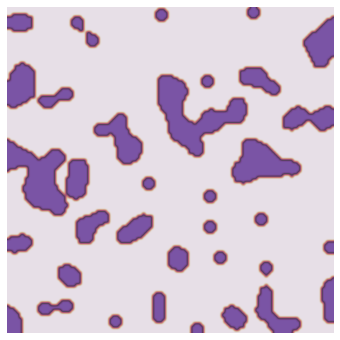

In [4]:
# initialize
N = 128
u, v = init_blobs(N)

# plot the u-component
fig, ax, im = plot_pattern(u, colormap='twilight');

On a 2D grid, we can discretize the Laplacian of each species concentration, for example $\nabla^2u$, as follows:

$$
\nabla^2u_{i,j} \approx \frac{-4u_{i,j}+u_{i+1,j}+u_{i-1,j}+u_{i,j+1}+u_{i,j-1}}{h^2}
$$

where $h$ is the lattice spacing. We'll use a square domain on $[-1,1]\times [-1,1]$ discretized into $N\times N$ grid points with periodic boundaries; thus our spacing is given by $h=2/N$.

You'll notice that the sum of the coefficients of the discrete Laplacian is zero. This enforces mass conservation; since the Laplacian of the concentration is proportional to the rate of inflow or outflow from any point in space, the outflow from any given point must equal the sum of inflow contributions that point makes to any of its neighbors. 

Since we'll need to perform two Laplace operations at each integration step, one for each species concentration, we will write a general function for the Laplace operator that can be repurposed several times.

In [5]:
# Compute the Laplacian over a 2D grid.
def laplacian2D(u, N):
    '''Compute the Laplacian of concentration.
    u - an array of concentrations.
    N - the system size in each dimension (2D).
    '''    
    h = 2./N
    h2i = 1./(h*h)
    lap = (-4*u + np.roll(u,1,axis=0) \
                + np.roll(u,-1,axis=0) \
                + np.roll(u,1,axis=1) \
                + np.roll(u,-1,axis=1))*h2i
    return lap

Our original set of equations is a system of PDEs, but by discretizing the spatial dimensions on an $N\times N$ grid, we convert our system to a set of ODEs with time as the continuous integration variable. The Gray-Scott system of ODEs is defined in the function ```gray_scott``` below.

In [6]:
def gray_scott(t, q, N, Du, Dv, f, k):
    '''Spatially discretized PDE for the Gray-Scott reaction-diffusion system.
        t - the current time.
        q - a linear array of concentrations u and v.
        N - the system size in each dimension.
        Du, Dv - the diffusion constants.
        f - the feed rate.
        k - the kill rate.
    '''
    u, v = q[:N*N].reshape(N,N), q[N*N:].reshape(N,N) # unpack the species concentrations
    
    # compute the Laplacians.
    Lu = laplacian2D(u, N)
    Lv = laplacian2D(v, N)

    du = Du*Lu - u*v*v + f*(1 - u)
    dv = Dv*Lv + u*v*v - (f + k)*v
    
    dq = np.zeros(2*N*N)
    dq[:N*N], dq[N*N:] = du.ravel(), dv.ravel()
    return dq

Finally, the function ```solve``` integrates the ODEs using the function ```solve_ivp``` from the Python ```scipy``` library.

In [7]:
def solve(fun, ti, tf, nt, qi, args):
    '''
    fun - the function to integrate
    ti, tf - starting and ending integration times.
    nt - number of equally spaced output points on [ti, tf].
    qi - initial conditions [u, v].
    args - tuple of model parameters (Du, Dv, a, b, c).
    rtol, atol - tolerance for tuning the accuracy of the solver.
    '''
    u, v = qi                           # unpack initial components
    N = len(u)                          # extract grid dimension
    t_eval = np.linspace(ti, tf, nt)    # evaluation points
    Du, Dv, f, k = args                 # unpack extra arguments
    
    start_time = time.time()            # time the integration
    
    # integrate the differential equation using finite differences
    sol = solve_ivp(lambda t, y: fun(t, y, N, Du, Dv, f, k), [ti, tf], 
                    np.hstack([u.ravel(), v.ravel()]), t_eval=t_eval, method='RK23')
    u = sol.y[:N*N,:].reshape(N,N,len(t_eval))
    
    # print elapsed time
    print('elapsed time (s): ', time.time() - start_time)
    
    return u

elapsed time (s):  5.786104917526245


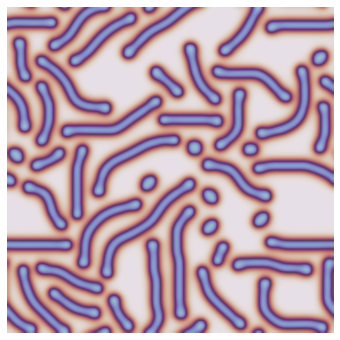

In [8]:
# parameters
Du = 2e-5
Dv = 1e-5
f = 0.058
k = 0.065

ti = 0
tf = 6000
frames = 100

# solve
out = solve(gray_scott, ti, tf, frames, [u, v], args = (Du, Dv, f, k))
fig, ax, im = plot_pattern(out[:,:,-1], colormap='twilight');

In [9]:
# create animation
ani = animate_pattern(out)
HTML(ani.to_html5_video())

With our integration routine set up, let's explore some of the varied patterns of the Gray-Scott system using an interactive widget. The following widget features some presets of feed and kill rates to try as starting points.

In [10]:
@widgets.interact_manual(presets = ['puffs','stripes','cells','worms','bubbles'])
def interactive_menu_plot(presets='puffs'):
    h = display(display_id=True)
    puffs = [0.010, 0.047]
    stripes = [0.030, 0.057]
    cells = [0.026, 0.061]
    worms = [0.058, 0.065]
    bubbles = [0.090, 0.059]
    
    inverse=False
    if presets in ['bubbles']:
        inverse=True
    
    # get parameters
    f, k = eval(presets)
    Du = 2e-5
    Dv = 1e-5
    
    # initialize u and v
    N = 128
    u, v = init_blobs(N, inverse)
    
    # solve
    ti = 0
    tf = 6000
    frames = 100
    out = solve(gray_scott, ti, tf, frames, [u, v], args = (Du, Dv, f, k))

    # create animation
    print('creating animation...')
    ani = animate_pattern(out, colormap='twilight')

    # display animation
    h.display(HTML(ani.to_html5_video()))

interactive(children=(Dropdown(description='presets', options=('puffs', 'stripes', 'cells', 'worms', 'bubbles'…

To more flexibly vary the model parameters, the widget below provides sliders for the feed and kill rates.

In [11]:
feed_slider = widgets.FloatSlider(
    value=0.03, min=0.01, max=0.1, step=0.001,
    description='Feed rate:', readout_format='.3f',)
kill_slider = widgets.FloatSlider(
    value=0.057, min=0.04, max=0.07, step=0.001,
    description='Kill rate:', readout_format='.3f',)

@widgets.interact_manual(f=feed_slider, k=kill_slider, inverse=['True', 'False'])
def interactive_slider_plot(f=0.03, k=0.057, inverse='False'):
    h = display(display_id=True)

    # initialize u and v
    N = 128
    u, v = init_blobs(N, eval(inverse))
    
    # solve
    Du = 2e-5
    Dv = 1e-5
    ti = 0
    tf = 6000
    frames = 100
    out = solve(gray_scott, ti, tf, frames, [u, v], args = (Du, Dv, f, k))
    
    # create animation
    print('creating animation...')
    ani = animate_pattern(out, colormap='twilight')

    # display animation
    h.display(HTML(ani.to_html5_video()))

interactive(children=(FloatSlider(value=0.03, description='Feed rate:', max=0.1, min=0.01, readout_format='.3f…

We can also seed the reaction with an image! A number of different silhouettes are provided in the Github repository.

In [12]:
!git clone https://github.com/gvarnavi/generative-art-iap.git
%cd generative-art-iap/01.28-Friday

Cloning into 'generative-art-iap'...
remote: Enumerating objects: 3360, done.
remote: Counting objects: 100% (1738/1738), done.
remote: Compressing objects: 100% (1500/1500), done.
remote: Total 3360 (delta 503), reused 1447 (delta 236), pack-reused 1622
Receiving objects: 100% (3360/3360), 398.38 MiB | 23.64 MiB/s, done.
Resolving deltas: 100% (1080/1080), done.
/content/generative-art-iap/01.28-Friday


In [13]:
# print contents
%ls icons

basketball.png  dinosaur.png  egg.png    heart.png  pretzel.png
dandelion.png   dragon.png    gecko.png  moon.png   shapes.png


In [14]:
import cv2

# convert a black and white image to a mask, resizing as necessary.
def init_image(N, image, inverse=False):
    '''Initialize values of a two-component system on a custom pattern.'''
    mask = imread("icons/"+image+".png", as_gray=True)
    m, n = mask.shape
    scale = 128./min(m,n)
    width = int(n*scale)
    height = int(m*scale)
    dim = (width, height)
    mask = cv2.resize(mask, dim)
    m, n = mask.shape
    mask = mask[m//2-N//2:m//2+N//2,n//2-N//2:n//2+N//2]
    mask[mask > 0] = 1
    mask = np.logical_not(mask)

    # initialize concentrations
    if inverse:
        u = np.zeros((N,N)); u[mask] = 0.5
        v = np.ones((N,N)); v[mask] = 0.25
    else:
        u = np.ones((N,N)); u[mask] = 0.5
        v = np.zeros((N,N)); v[mask] = 0.25
    return u, v

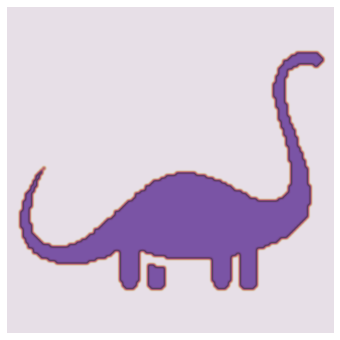

In [15]:
# initialize u and v based on seed image
N = 128
u, v = init_image(N, 'dinosaur')
plot_pattern(u, colormap='twilight');
plt.show()

elapsed time (s):  5.850439548492432


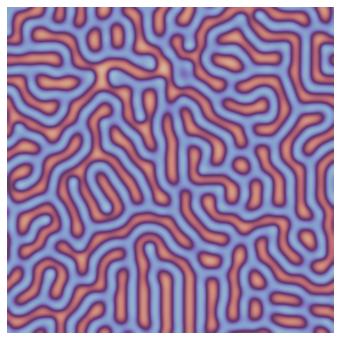

In [16]:
# set parameters
Du = 2e-5
Dv = 1e-5
f = 0.0545
k = 0.062

ti = 0
tf = 6000
frames = 100

# solve
out = solve(gray_scott, ti, tf, frames, [u, v], args = (Du, Dv, f, k))
fig, ax, im = plot_pattern(out[:,:,-1], colormap='twilight');

In [17]:
# create animation
ani = animate_pattern(out, colormap='twilight')

# display animation
HTML(ani.to_html5_video())